In [1]:
%pylab inline
from __future__ import print_function, division

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nibabel as nib
import numpy as np
import os
import stat
import os.path as osp
import matplotlib.pyplot as plt
import nipy
import json
import scipy.linalg as lin
import scipy.stats as sst
from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse

In [3]:
HOME = osp.expanduser('~')
atlas_rois = osp.join(HOME,'code', 'regions', 'regions','tmp')
DDIR = osp.join(HOME,'data','simpace','data','rename_files','sub01','sess01','preproc')
DSRA = osp.join(DDIR, 'smooth')

runs_pat = ['*sess01_run{:02d}-0*'.format(i) for i in [1,2,3,4]]

runs = [gb.glob(osp.join(DSRA, pat)) for pat in runs_pat]
for run in runs: run.sort()
print([len(run) for run in runs])
print('\n'.join(runs[0][:4]))

[196, 196, 196, 196]
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0005.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0006.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0007.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0008.nii


In [4]:
mask_file = osp.join(DDIR, 'sess_mask', 'sess_mask.nii')
mask_img = nib.load(mask_file)
print(mask_img.shape)

(64, 64, 30)


In [24]:
run = runs[1]
arr = np.zeros(mask_img.shape+(len(run),), dtype=float32)
for idx, fn in enumerate(run):
    vol = nib.load(fn)
    arr[...,idx] = vol.get_data()
    
print(arr[:,:,:,0].mean())

173.136


(64, 64, 30, 196)


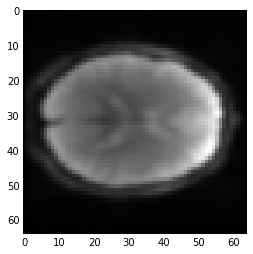

In [35]:
mask_arr = mask_img.get_data()
sli = 12
print(arr.shape)
plt.imshow(arr[:,:,sli,0],interpolation='nearest',cmap='gray')

196


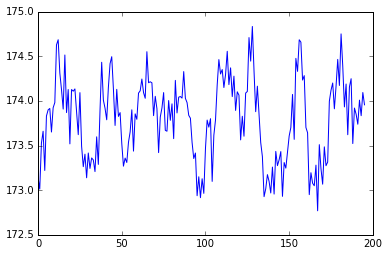

In [36]:
arr_resh = arr.copy()
arr_resh = arr_resh.reshape(np.prod(mask_img.shape),len(run))
plt.plot(arr_resh.mean(axis=0))
print(len(run))

In [37]:
from utils import _utils as uti

In [38]:
from nilearn._utils import concat_niimgs
run_4d = concat_niimgs(run, ensure_ndim=4)
signals, issues, info = uti.extract_signals(osp.join(DDIR, 'sess_mask'), 'sess_*', run_4d, 
                                      mask=mask_file, verbose=True)

['/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/sess_mask/sess_mask.nii'] 

In mask:29641, out:122880
nb voxels in mask of sess_mask is 29641 



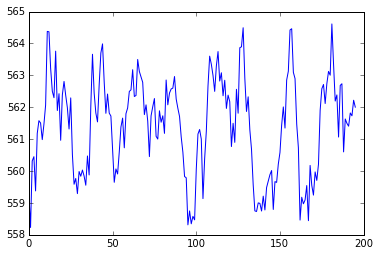

In [39]:
plt.plot(signals['sess_mask'])

### Regression

In [40]:
gsig = signals['sess_mask']
intercept = np.ones(gsig.shape)
X = np.vstack((gsig, intercept)).T
X.shape

(196, 2)

In [44]:
betas = lin.pinv(X).dot(arr_resh.T)

In [45]:
beta0 = betas[0].reshape(mask_img.shape)

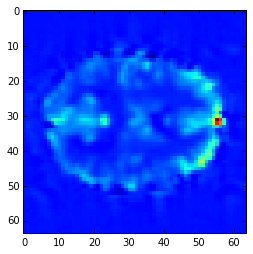

In [46]:
plt.imshow(beta0[:,:,12],interpolation='nearest',cmap='jet')